### 项目概述

    The data scientists at BigMart have collected 2013 sales data for 1559 products across 10 stores in different cities. Also, certain attributes of each product and store have been defined. The aim is to build a predictive model and find out the sales of each product at a particular store.

    Using this model, BigMart will try to understand the properties of products and stores which play a key role in increasing sales.
    Please note that the data may have missing values as some stores might not report all the data due to technical glitches. Hence, it will be required to treat them accordingly.
    BigMart的数据科学家已经收集了2013年的销售数据，包括各个不同城市的10家店的1559项产品。并且，每一项产品和门店的各个属性已经存储定义好了。这个项目旨在建立一个预测模型，探寻出在特定门店里每个产品的销售情况。
    通过使用这个模型，BigMart将尽力去了解产品和门店的哪些特性在销量的增长上起关键性作用。
    请注意数据集存在缺失现象，因为一些门店可能由于技术问题无法上传所有数据。因此需要好好处理缺失问题。

### 引入分析需要的模块

In [1]:
import numpy as np
import pandas as pd
#ignore warnings
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# import model Algorithm and data enginering tools
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
#ignore warnings
import warnings
warnings.filterwarnings('ignore')

### 导入数据，观察整体状况

In [3]:
train = pd.read_csv("./BigMartSales/train.csv")
train_engin = train.copy()
test = pd.read_csv("./BigMartSales/test.csv")

In [4]:
train.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales'],
      dtype='object')

In [5]:
train.shape

(8523, 12)

In [6]:
test.shape

(5681, 11)

    可以看到，训练集包含8523项数据，每项数据有12个属性，测试集包含5681项数据，每项数据有11个属性值。
    下面对各个属性分别介绍。

|Variable | Description   |
|:---------------- | :---------------------|
|Item_Identifier | 每个产品独立的ID |
|Item_Weight | 每个产品的重量 |
|Item_Fat_Content | 一个产品是否是低脂的 |
|Item_Visibility |分配给特定产品展示的区域占所有展区的百分比 |
|Item_Type | 产品类别|
|Item_MRP | 产品的最大零售价格 |
|Outlet_Identifier| 门店的独立ID |
|Outlet_Establishment_Year | 创立门店的年份 |
|Outlet_Size | 门店的占地面积 |
|Outlet_Location_Type | 门店所在城市的类别 |
|Outlet_Type |门店的类型，百货店或者其他类的超市 |
|Item_Outlet_Sales | 产品在门店的销售额 |

    下面我结合以上的参数做一些假设性推断，即那些因素会影响销售额，主要分为两类：产品和门店。
    产品方面的假设：
    1. 产品的品牌，品牌产品往往比不知名产品的销售额大，因为人们往往更信得过有品牌的产品。
    2. 产品的包装，外包装精美可以吸引更多的人购买。
    3. 产品的消费类型，日常使用的快消耗品由于日常需求销售量一般都大。
    4. 产品的广告宣传，广告宣传力度大的产品销售额也大。
    5. 产品是否在店铺里有特定的展区，产品有特定展区的更能够吸引顾客的注意，因而销售量要大。
    6. 产品在店铺的摆放位置，靠近店铺入口摆放的产品的销售量要大。
    7. 产品是否有促销，有促销的产品销售额大。
    8. 产品的定价策略，产品的定价要符合产品的价值，不能虚高和过低。
    门店方面的假设：
    1. 门店的品牌，品牌意味着信誉和忠诚度，一个连锁店的品牌知名度越高，越能成为顾客消费的选择，销售额也就越高，而且商品的采购渠道和进价的议价能力越强，毛利润也就越高。
    2. 门店所在的城市的类型。城市等级越高，人们的收入越高，消费水平越高，那么销售额必然高。
    3. 门店的规模，规模越大，商品的种类越多，越能成为顾客一站式消费的场所，销售额越高。
    4. 门店的区位和地段，门店所在的地段越繁华，人口流动量也就越大，顾客的消费量也就越大。
    5. 竞争对手。如果门店的附近有同类的竞争对手势必会影响其销售量。
    6. 营销能力。门店的营销能力和销售量是正相关的。
    7. 服务水平。顾客满意度和店员的服务态度等也会影响销售额。
    8. 门店的创立时间。门店的创立时间越长，人们的知晓程度越高。

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
Item_Identifier              8523 non-null object
Item_Weight                  7060 non-null float64
Item_Fat_Content             8523 non-null object
Item_Visibility              8523 non-null float64
Item_Type                    8523 non-null object
Item_MRP                     8523 non-null float64
Outlet_Identifier            8523 non-null object
Outlet_Establishment_Year    8523 non-null int64
Outlet_Size                  6113 non-null object
Outlet_Location_Type         8523 non-null object
Outlet_Type                  8523 non-null object
Item_Outlet_Sales            8523 non-null float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.1+ KB


    属于类别型特征值的有:Item_Identifier,Item_Fat_content,Item_Type,Outlet_Identifier,Outlet_Size, Outlet_Location_Type,Outlet_Type
    其他属性都是数字型的。

In [8]:
train["Outlet_Identifier"].value_counts()

OUT027    935
OUT013    932
OUT046    930
OUT035    930
OUT049    930
OUT045    929
OUT018    928
OUT017    926
OUT010    555
OUT019    528
Name: Outlet_Identifier, dtype: int64

    数据集一共包含10个门店，一个门店的最大产品数为935项，最小的也有528项。

In [9]:
train["Outlet_Establishment_Year"].value_counts()

1985    1463
1987     932
1999     930
1997     930
2004     930
2002     929
2009     928
2007     926
1998     555
Name: Outlet_Establishment_Year, dtype: int64

In [10]:
df1 = train["Outlet_Establishment_Year"].groupby(train["Outlet_Identifier"]).value_counts()
df2 = train["Outlet_Size"].groupby(train["Outlet_Identifier"]).value_counts()
df3 = train["Outlet_Location_Type"].groupby(train["Outlet_Identifier"]).value_counts()
df4 = train["Outlet_Type"].groupby(train["Outlet_Identifier"]).value_counts()
df1

Outlet_Identifier  Outlet_Establishment_Year
OUT010             1998                         555
OUT013             1987                         932
OUT017             2007                         926
OUT018             2009                         928
OUT019             1985                         528
OUT027             1985                         935
OUT035             2004                         930
OUT045             2002                         929
OUT046             1997                         930
OUT049             1999                         930
Name: Outlet_Establishment_Year, dtype: int64

    Outlet_Establishment_Year属性包含9个年份，分别对应着每个门店的创建时间，OUT019和OUT027同时创建于1985年。可以借助这个属性产生新的属性，门店的年长。

In [11]:
df2

Outlet_Identifier  Outlet_Size
OUT013             High           932
OUT018             Medium         928
OUT019             Small          528
OUT027             Medium         935
OUT035             Small          930
OUT046             Small          930
OUT049             Medium         930
Name: Outlet_Size, dtype: int64

In [12]:
train["Outlet_Size"].isnull().groupby(train["Outlet_Identifier"]).sum()

Outlet_Identifier
OUT010    555.0
OUT013      0.0
OUT017    926.0
OUT018      0.0
OUT019      0.0
OUT027      0.0
OUT035      0.0
OUT045    929.0
OUT046      0.0
OUT049      0.0
Name: Outlet_Size, dtype: float64

    门店规模包含7个值分别对应7家门店，有3家门店缺失。规模分为Small,medium,high。

In [13]:
df3

Outlet_Identifier  Outlet_Location_Type
OUT010             Tier 3                  555
OUT013             Tier 3                  932
OUT017             Tier 2                  926
OUT018             Tier 3                  928
OUT019             Tier 1                  528
OUT027             Tier 3                  935
OUT035             Tier 2                  930
OUT045             Tier 2                  929
OUT046             Tier 1                  930
OUT049             Tier 1                  930
Name: Outlet_Location_Type, dtype: int64

In [14]:
train["Outlet_Identifier"].groupby(train["Outlet_Location_Type"]).value_counts()

Outlet_Location_Type  Outlet_Identifier
Tier 1                OUT046               930
                      OUT049               930
                      OUT019               528
Tier 2                OUT035               930
                      OUT045               929
                      OUT017               926
Tier 3                OUT027               935
                      OUT013               932
                      OUT018               928
                      OUT010               555
Name: Outlet_Identifier, dtype: int64

Outlet_Location_Type包含3个值，其中，OUT046，049，019所属的城市类别是Tier1,OUT035,045,017所属的城市类别是Tier2,OUT027,013,018,010所属的城市类别是Tier3。

In [15]:
train["Outlet_Identifier"].groupby(train["Outlet_Type"]).value_counts()

Outlet_Type        Outlet_Identifier
Grocery Store      OUT010               555
                   OUT019               528
Supermarket Type1  OUT013               932
                   OUT035               930
                   OUT046               930
                   OUT049               930
                   OUT045               929
                   OUT017               926
Supermarket Type2  OUT018               928
Supermarket Type3  OUT027               935
Name: Outlet_Identifier, dtype: int64

Outlet_Type包含4个值，Grocery Store：OUT010和OUT019，Supermarket Type1：OUT013，OUT035，OUT046，OUT049，OUT045，OUT017，Supermarket Type2：OUT018，Supermarket Type3：OUT027.

In [16]:
len(train["Item_Identifier"].unique())

1559

一共包含1559项产品

In [17]:
train["Item_Fat_Content"].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

   含脂率包含五个值：Low Fat,Regular,LF,reg,Low fat。类别名称没有统一，LOw Fat,Lf,Low fat 都是低脂的意思，Regular,LF,都是正常水平的意思。

In [18]:
train["Item_Type"].value_counts()

Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64

    F and V 水果和蔬菜
    Snack foods 点心，小吃
    Households 日用品
    F foods 冷冻食品
    Dairy 乳制品
    Canned 罐装食品
    baking goods 烘焙制品
    health and Hygiene 卫生保健用品
    Soft Drinks 饮料
    meat 肉
    breads 面包
    hard drinks 酒
    others 其他
    Starchy foods 淀粉类食物
    Breakfast 早餐
    Seafood 海鲜
包含各种种类的食物，食物的种类有点偏多，我们可以把一些同类型的产品归为一类。food, drink 和Others

In [19]:
train.isnull().sum() / len(train)

Item_Identifier              0.000000
Item_Weight                  0.171653
Item_Fat_Content             0.000000
Item_Visibility              0.000000
Item_Type                    0.000000
Item_MRP                     0.000000
Outlet_Identifier            0.000000
Outlet_Establishment_Year    0.000000
Outlet_Size                  0.282764
Outlet_Location_Type         0.000000
Outlet_Type                  0.000000
Item_Outlet_Sales            0.000000
dtype: float64

In [20]:
test.isnull().sum()

Item_Identifier                 0
Item_Weight                   976
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  1606
Outlet_Location_Type            0
Outlet_Type                     0
dtype: int64

In [21]:
test.isnull().sum() / len(test)

Item_Identifier              0.000000
Item_Weight                  0.171801
Item_Fat_Content             0.000000
Item_Visibility              0.000000
Item_Type                    0.000000
Item_MRP                     0.000000
Outlet_Identifier            0.000000
Outlet_Establishment_Year    0.000000
Outlet_Size                  0.282697
Outlet_Location_Type         0.000000
Outlet_Type                  0.000000
dtype: float64

共有两项属性有缺失值，分别是Item_Weight和Outlet_Size,train中分别占总数的17%，28%，test中分别占总数的17%，28%。缺失情况基本一致。

    再来看一下数字型属性的统计量：

In [22]:
train.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


    由于不知道单位，只能按照尺度来衡量大小，由上图分析得到：
    1. 产品的重量在4.555-21.35之间，平均重量为12.857，重量的标准差为4.64。
    2. 产品的展示区域占比，最惨是没有展示区域，最大达到了32.8%，平均为6.6%。
    3. 产品的最大零售价格在31.29-266.89之间，平均价格为140.99。
    4. 门面的创建年份的统计量没有实际意义。
    5. 产品在该门店的销售额在33.29-13085.96之间，平均销售额2181.29。

       下面我来分析一下不同features对销售额的影响:
       不同门店Item_Visibility和Item_Outlet_Sales的关系：

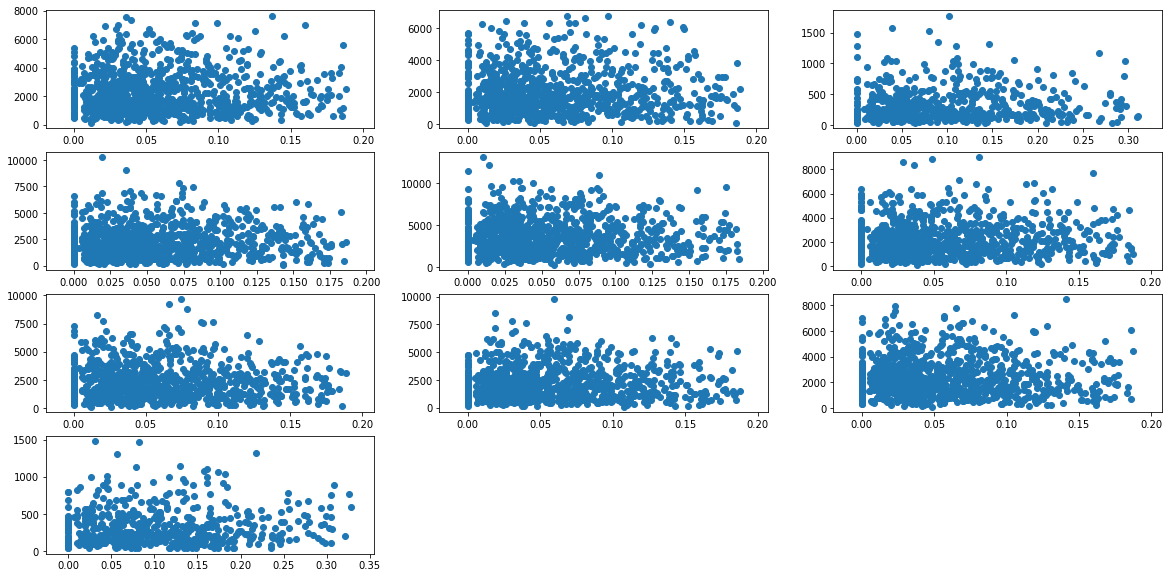

In [23]:
plt.figure(figsize=(20,10))
outlets = train["Outlet_Identifier"].unique()
for i in range(1,11):
    plt.subplot(4,3,i)
    plt.scatter(x=train["Item_Visibility"][train["Outlet_Identifier"] == outlets[i - 1]],
               y =train["Item_Outlet_Sales"][train["Outlet_Identifier"] == outlets[i - 1]])


所有产品的Item_Visibility与销售额的关系:

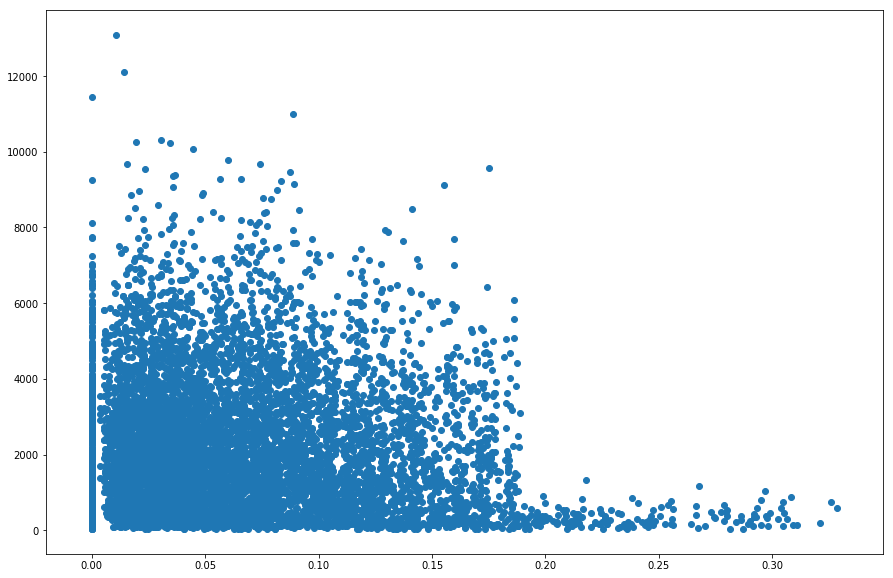

In [24]:
plt.figure(figsize=(15,10))
plt.scatter(x=train.Item_Visibility,y=train.Item_Outlet_Sales)

单个产品的Item_Visibility与销售额的关系:

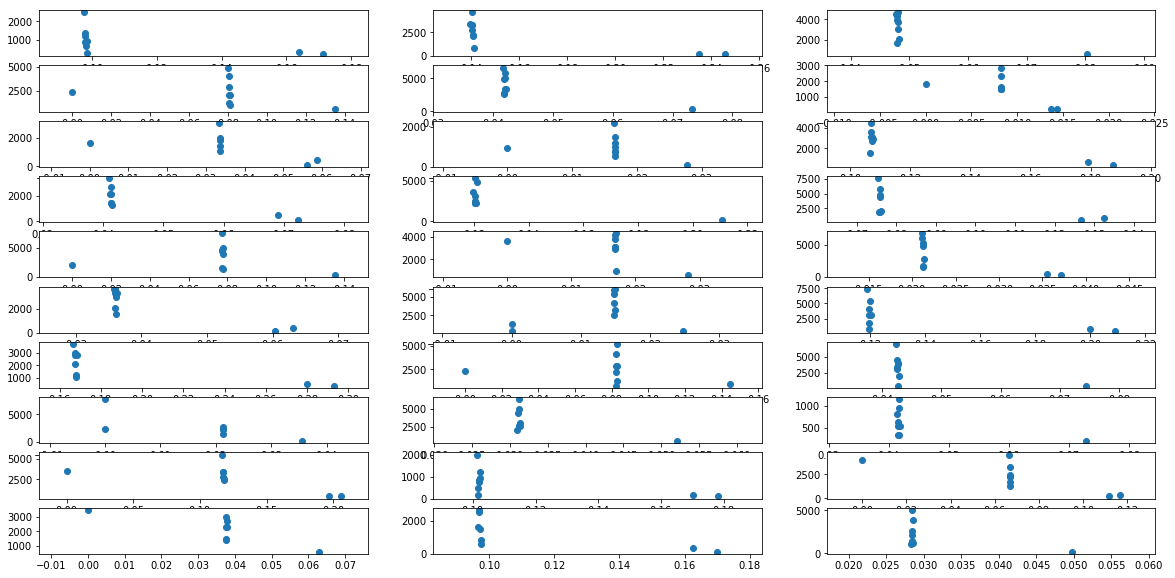

In [25]:
products = train["Item_Identifier"].value_counts().index
plt.figure(figsize=(20,10))
for i in range(1,31):
    plt.subplot(10,3,i)
    plt.scatter(x=train["Item_Visibility"][train["Item_Identifier"] == products[i - 1]],
               y =train["Item_Outlet_Sales"][train["Item_Identifier"] == products[i - 1]])



由以上我们发现，无论是每个门店的所有的产品的特殊展区面积，还是单个产品在不同门店的特殊展区面积与销售额之间并没有很明显的相关性，也就是说，大多数情况下，增加产品的展区面积并不能增加销售，这仅是从数据上得来，与正常的规律不同。相同产品在不同门店的展区面积基本相同，少数有点差异。

In [26]:
train["Item_Fat_Content"].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [27]:
train["Item_Fat_com"] = train["Item_Fat_Content"].map({"LF":1,"Low Fat":1,"Regular":0,"low fat":1,"reg":0})
pd.pivot_table(train, index=["Item_Fat_com"],values=['Item_Outlet_Sales'])

,Item_Outlet_Sales
Item_Fat_com,
0,2224.561170
1,2157.711534


In [28]:
train["Item_Fat_com"] = train["Item_Fat_Content"].map({"LF":1,"Low Fat":1,"Regular":0,"low fat":1,"reg":0})
pd.pivot_table(train, index=["Outlet_Identifier","Item_Fat_com"],values=['Item_Outlet_Sales'])

Item_Outlet_Sales
Outlet_Identifier Item_Fat_com                   
OUT010            0                    324.862843
                  1                    347.261992
OUT013            0                   2247.432408
                  1                   2326.733685
OUT017            0                   2402.306671
                  1                   2306.228079
OUT018            0                   1971.266341
                  1                   2008.871133
OUT019            0                    349.888875
                  1                    335.301498
OUT027            0                   3785.873978
                  1                   3643.946510
OUT035            0                   2458.108941
                  1                   2428.540658
OUT045            0                   2323.542130
                  1                   2123.467973
OUT046            0                   2398.149432
                  1                   2211.052771
OUT049            0                   2375.588354
                  1                   2333.092785

含脂率方面，低脂和正常的产品的平均销售额基本一致，没有发现相关性。
    对于Outlet_Establishment_Year，本身并没有什么意义，因此引进一个新的history_year来代表创建的年限。

In [31]:
train["history_year"] = 2018 - train["Outlet_Establishment_Year"]
pd.pivot_table(train, index=["Outlet_Identifier","history_year"],values=["Item_Outlet_Sales"]).sort_index(by="Item_Outlet_Sales")

,,Item_Outlet_Sales
Outlet_Identifier,history_year,
OUT010,20,339.351662
OUT019,33,340.329723
OUT018,9,1995.498739
OUT045,16,2192.384798
OUT046,21,2277.844267
OUT013,31,2298.995256
OUT017,11,2340.675263
OUT049,19,2348.354635
OUT035,14,2438.841866


门店的开店时长并没有与销售额有很大的相关性。

In [32]:
pd.pivot_table(train, index=["Outlet_Size"],values=["Item_Outlet_Sales"])

,Item_Outlet_Sales
Outlet_Size,
High,2298.995256
Medium,2681.603542
Small,1912.149161


门店规模的平均销售额对比，门店规模的划分好像并没有参考销售额的大小。

In [33]:
pd.pivot_table(train, index=["Outlet_Location_Type"],values=["Item_Outlet_Sales"])

,Item_Outlet_Sales
Outlet_Location_Type,
Tier 1,1876.909159
Tier 2,2323.990559
Tier 3,2279.627651


门店所在城市的类别方面，Tie2,3好像临界于1线2线城市之间，Tier1是三线城市。

In [34]:
pd.pivot_table(train, index=["Outlet_Type"],values=["Item_Outlet_Sales"])

,Item_Outlet_Sales
Outlet_Type,
Grocery Store,339.828500
Supermarket Type1,2316.181148
Supermarket Type2,1995.498739
Supermarket Type3,3694.038558


门店种类上，Grocery Store类别显然是一类小便利店百货店，销售额远远小于其他三类。超市Type1,Type2相似，Type3的销售额最高，而且高很多。

In [35]:
pd.pivot_table(train, index=["Outlet_Identifier","Outlet_Location_Type","Outlet_Type"],values=["Item_Outlet_Sales"]).sort_index(by="Item_Outlet_Sales")

,,,Item_Outlet_Sales
Outlet_Identifier,Outlet_Location_Type,Outlet_Type,
OUT010,Tier 3,Grocery Store,339.351662
OUT019,Tier 1,Grocery Store,340.329723
OUT018,Tier 3,Supermarket Type2,1995.498739
OUT045,Tier 2,Supermarket Type1,2192.384798
OUT046,Tier 1,Supermarket Type1,2277.844267
OUT013,Tier 3,Supermarket Type1,2298.995256
OUT017,Tier 2,Supermarket Type1,2340.675263
OUT049,Tier 1,Supermarket Type1,2348.354635
OUT035,Tier 2,Supermarket Type1,2438.841866


以上三种对门店的分类方式并不能完全在销售额上体现出区别。但是经过分析发现，Grocery Store类的门店的销售额必然底，而Tier3和Supermarket Type3的销售额必然高，对于其他类型的门店则都差不多。

In [36]:
size_miss = train[train["Outlet_Size"].isnull()]
pd.pivot_table(size_miss,index=["Outlet_Type","Outlet_Identifier"],values=["Item_Outlet_Sales"])

Item_Outlet_Sales
Outlet_Type       Outlet_Identifier                   
Grocery Store     OUT010                    339.351662
Supermarket Type1 OUT017                   2340.675263
                  OUT045                   2192.384798

In [37]:
table = pd.pivot_table(train,index=["Outlet_Type","Outlet_Size"],values=["Item_Outlet_Sales"])
table

Item_Outlet_Sales
Outlet_Type       Outlet_Size                   
Grocery Store     Small               340.329723
Supermarket Type1 High               2298.995256
                  Medium             2348.354635
                  Small              2358.343066
Supermarket Type2 Medium             1995.498739
Supermarket Type3 Medium             3694.038558

以上总结如下：
    在train集中一共包含1559项产品，每一件产品的重量都一致。每件产品分为Low_Fat和Regular,产品的展区面积与销售额并没有很大的相关性。产品的种类有13种，经过分析发现可以聚合为食物，饮料和其他三类。每件产品的最高零售价格在不同门店都不一样，可能跟门店的地区和门店的类型有关。门店一共有10家，开店的时长都不一样。门店有几种分类方式，第一种是按门店的规模来分为：High,Medium,Small,这里有部分门店缺失。第二种是根据所在城市的类别分为：Tier1,Tier2,Tier3。第三种是门店的类型分为：Grocery Store，Supermarket Type1，Supermarket Type2，Supermarket Type3.
经过分析发现，门店类型的Grocery Store的规模肯定是最小的，与其他店的差异性很大。还有就是Tier3并且是SupermarketType3的门店的销量的最高，与其他的差异性很大。对于缺失的三家门店的Outlet_Size, OUT010由于是Grocery Store，size 肯定是Small,其他两家可以填充为Medium

### Data Cleaning

下面进行数据处理，先把train,test合并起来便于处理。

In [38]:
train_len = len(train_engin)
dataset = pd.concat([train_engin,test],axis = 0)
dataset.shape

(14204, 12)

十家门店的ID

In [39]:
store_name = list(dataset["Outlet_Identifier"].value_counts().index)

In [ ]:
对于数据集缺失值得处理，Item_Weight,因为每个产品的重量是一定的，因此可以根据产品的ID来填充相对应的产品的重量。

In [40]:
item_ave_weight = dataset.pivot_table(values="Item_Weight",index='Item_Identifier')

In [41]:
dataset.loc[dataset["Item_Weight"].isnull(),"Item_Weight"] = dataset.loc[dataset["Item_Weight"].isnull(),"Item_Identifier"].apply(lambda x: item_ave_weight.ix[x])

就如之间分析的，对于Outlet_Size的缺失值，OUT010由于是Grocery Store，size 肯定是Small,其他两家可以填充为Medium。

In [42]:
dataset["Outlet_Size"][dataset["Outlet_Identifier"] == 'OUT010'].fillna("Small", inplace = True)
dataset["Outlet_Size"].fillna("Medium", inplace=True)

产品类别Item_Type，发现每个产品Item_Identifier的前两个字母都包含：FD,DR,NC，猜想可能是超市做产品类别统计时所用的标签，分别代表
Food,Drinks,Non-Consumables,因此可以用这三个类别来重新分类产品，此外可以用平均销售额来划分类别。

In [43]:
pd.pivot_table(dataset, index=["Item_Type"],values = ["Item_Outlet_Sales"]).sort_index(by="Item_Outlet_Sales")

,Item_Outlet_Sales
Item_Type,
Others,1926.139702
Baking Goods,1952.971207
Soft Drinks,2006.511735
Health and Hygiene,2010.000265
Breakfast,2111.808651
Frozen Foods,2132.867744
Hard Drinks,2139.221622
Meat,2158.977911
Breads,2204.132226


In [45]:
dataset["Item_type1"] = dataset["Item_Identifier"].apply(lambda x: x[0:2])

In [46]:
dataset["Item_type1"].value_counts()

FD    10201
NC     2686
DR     1317
Name: Item_type1, dtype: int64

In [47]:
dataset["Item_type1"] = dataset["Item_type1"].map({"FD":0,"NC":1,"DR":2})

根据平均销量，把Item_Type分成五类：


In [48]:
dataset["Item_type2"] = dataset["Item_Type"].map({'Others':0, 'Baking Goods':0, 'Soft Drinks':1, 'Health and Hygiene':1,
       'Breakfast':2, 'Frozen Foods':2, 'Hard Drinks':2, 'Meat':2, 'Breads':3, 'Canned':3,
       'Dairy':3, 'Household':3, 'Snack Foods':3, 'Fruits and Vegetables':3, 'Seafood':4,
       'Starchy Foods':4})

In [49]:
dataset.Item_Fat_Content.value_counts()

Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64

In [50]:
dataset.sample(5)

,Item_Fat_Content,Item_Identifier,Item_MRP,Item_Outlet_Sales,Item_Type,Item_Visibility,Item_Weight,Outlet_Establishment_Year,Outlet_Identifier,Outlet_Location_Type,Outlet_Size,Outlet_Type,Item_type1,Item_type2
748,Regular,FDA01,58.5904,996.0368,Canned,0.054368,15.00,2004,OUT035,Tier 2,Small,Supermarket Type1,0,3
1664,Low Fat,NCO05,99.3384,2759.0752,Health and Hygiene,0.046823,7.27,2007,OUT017,Tier 2,Medium,Supermarket Type1,1,1
2332,Low Fat,FDK43,126.3020,NaN,Meat,0.026836,9.80,2004,OUT035,Tier 2,Small,Supermarket Type1,0,2
1351,Low Fat,FDM32,90.8830,89.8830,Fruits and Vegetables,0.000000,20.50,1998,OUT010,Tier 3,Medium,Grocery Store,0,3
3882,Regular,FDJ15,182.5608,3307.6944,Dairy,0.023322,11.35,1997,OUT046,Tier 1,Small,Supermarket Type1,0,3


    Item_Type中有三类：Household,Health and Hygiene,Others都是非食用类产品，它们都是Non-Consumables，由此我们推断Item_Fat_Content的一部分产品分类错误，应该是No_fat类。
    另外，由于Item_Fat_Content中的类别都不统一，需要处理。

In [51]:
dataset["Item_type1"][dataset["Item_Type"] == "Household"].value_counts()

1    1548
Name: Item_type1, dtype: int64

In [52]:
dataset["Item_type1"][dataset["Item_Type"] == "Health and Hygiene"].value_counts()

1    858
Name: Item_type1, dtype: int64

In [53]:
dataset["Item_type1"][dataset["Item_Type"] == "Others"].value_counts()

1    280
Name: Item_type1, dtype: int64

In [54]:
dataset["Item_Fat_Content"] = dataset["Item_Fat_Content"].map({"LF":"lf","Low Fat":"lf","Regular":"reg","low fat":"lf","reg":"reg"})

In [55]:
dataset["Item_Fat_Content"][dataset["Item_type1"] == 1] = 'No_fat' 

年限就像之间分析的进行处理。

In [57]:
dataset["Outlet_Year"] = 2018 - dataset["Outlet_Establishment_Year"]

新创建一个属性，小卖部便利店一个类别，大城市特大超市一个类别，其他超市一个类别。

In [58]:
dataset["Outlet_kind"] = dataset.apply(lambda x: 2 if (x["Outlet_Location_Type"] == "Tier 3" and x["Outlet_Type"] == "Supermarket Type3") else 0, axis =1)

In [59]:
dataset.loc[dataset["Outlet_Type"]=="Grocery Store", "Outlet_kind"] = 1

我们来看一下处理好后的数据情况：

In [60]:
dataset.sample(5)

,Item_Fat_Content,Item_Identifier,Item_MRP,Item_Outlet_Sales,Item_Type,Item_Visibility,Item_Weight,Outlet_Establishment_Year,Outlet_Identifier,Outlet_Location_Type,Outlet_Size,Outlet_Type,Item_type1,Item_type2,Outlet_Year,Outlet_kind
3954,lf,FDV15,104.4648,NaN,Meat,0.146145,10.300,2004,OUT035,Tier 2,Small,Supermarket Type1,0,2,14,0
6397,lf,FDD03,232.6300,1864.2400,Dairy,0.080258,13.300,2007,OUT017,Tier 2,Medium,Supermarket Type1,0,3,11,0
2729,lf,FDJ50,51.9982,NaN,Canned,0.021674,8.645,2009,OUT018,Tier 3,Medium,Supermarket Type2,0,3,9,0
3422,No_fat,NCE07,143.1154,1843.6002,Household,0.013184,8.180,2009,OUT018,Tier 3,Medium,Supermarket Type2,1,3,9,0
3550,No_fat,NCV18,84.9250,NaN,Household,0.105158,6.775,1987,OUT013,Tier 3,High,Supermarket Type1,1,3,31,0


需要将文本类别的属性进一步数字化处理。

In [61]:
labelencoder = LabelEncoder()
dataset["Outlet"] = labelencoder.fit_transform(dataset["Outlet_Identifier"])
category_features = ["Item_Fat_Content","Outlet","Outlet_Location_Type","Outlet_Size","Outlet_Type"]

In [62]:
dataset = pd.get_dummies(dataset,columns = category_features)

对于大尺度数据，进行特征缩放

In [64]:
std_scaler = StandardScaler()

In [65]:
std_features = ["Item_MRP","Item_Visibility","Item_Weight","Outlet_Year"]
for feature in std_features:
    dataset[feature] = std_scaler.fit_transform(dataset[feature])

再看一下数据情况

In [104]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14204 entries, 0 to 5680
Data columns (total 33 columns):
Item_Identifier                  14204 non-null object
Item_MRP                         14204 non-null float64
Item_Outlet_Sales                8523 non-null float64
Item_Visibility                  14204 non-null float64
Item_Weight                      14204 non-null float64
Outlet_Identifier                14204 non-null object
Item_type1                       14204 non-null int64
Item_type2                       14204 non-null int64
Outlet_Year                      14204 non-null float64
Outlet_kind                      14204 non-null int64
Item_Fat_Content_No_fat          14204 non-null uint8
Item_Fat_Content_lf              14204 non-null uint8
Item_Fat_Content_reg             14204 non-null uint8
Outlet_0                         14204 non-null uint8
Outlet_1                         14204 non-null uint8
Outlet_2                         14204 non-null uint8
Outlet_3         

In [66]:
dataset.sample(5)

,Item_Identifier,Item_MRP,Item_Outlet_Sales,Item_Type,Item_Visibility,Item_Weight,Outlet_Establishment_Year,Outlet_Identifier,Item_type1,Item_type2,...,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Size_High,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
3599,NCS30,-0.193925,1808.3128,Household,-1.281712,-1.472279,2007,OUT017,1,3,...,0,1,0,0,1,0,0,1,0,0
7867,FDP22,-1.419646,461.3994,Snack Foods,0.644437,0.399140,2004,OUT035,0,3,...,0,1,0,0,0,1,0,1,0,0
6548,FDC20,-1.359074,447.4176,Fruits and Vegetables,-0.813221,-0.460788,2007,OUT017,0,3,...,0,1,0,0,1,0,0,1,0,0
1315,FDZ57,-0.182099,1413.4934,Snack Foods,-0.544819,-0.600527,2009,OUT018,0,3,...,0,0,1,0,1,0,0,0,1,0
1802,DRN36,-0.731738,NaN,Soft Drinks,-0.301051,0.517380,2007,OUT017,2,1,...,0,1,0,0,1,0,0,1,0,0


好了，把无用的属性去掉，特征工程就完成了。查看一下属性间的相关性。

In [67]:
drop_feature = ["Item_Type", "Outlet_Establishment_Year"]
dataset.drop(drop_feature, axis=1, inplace=True)

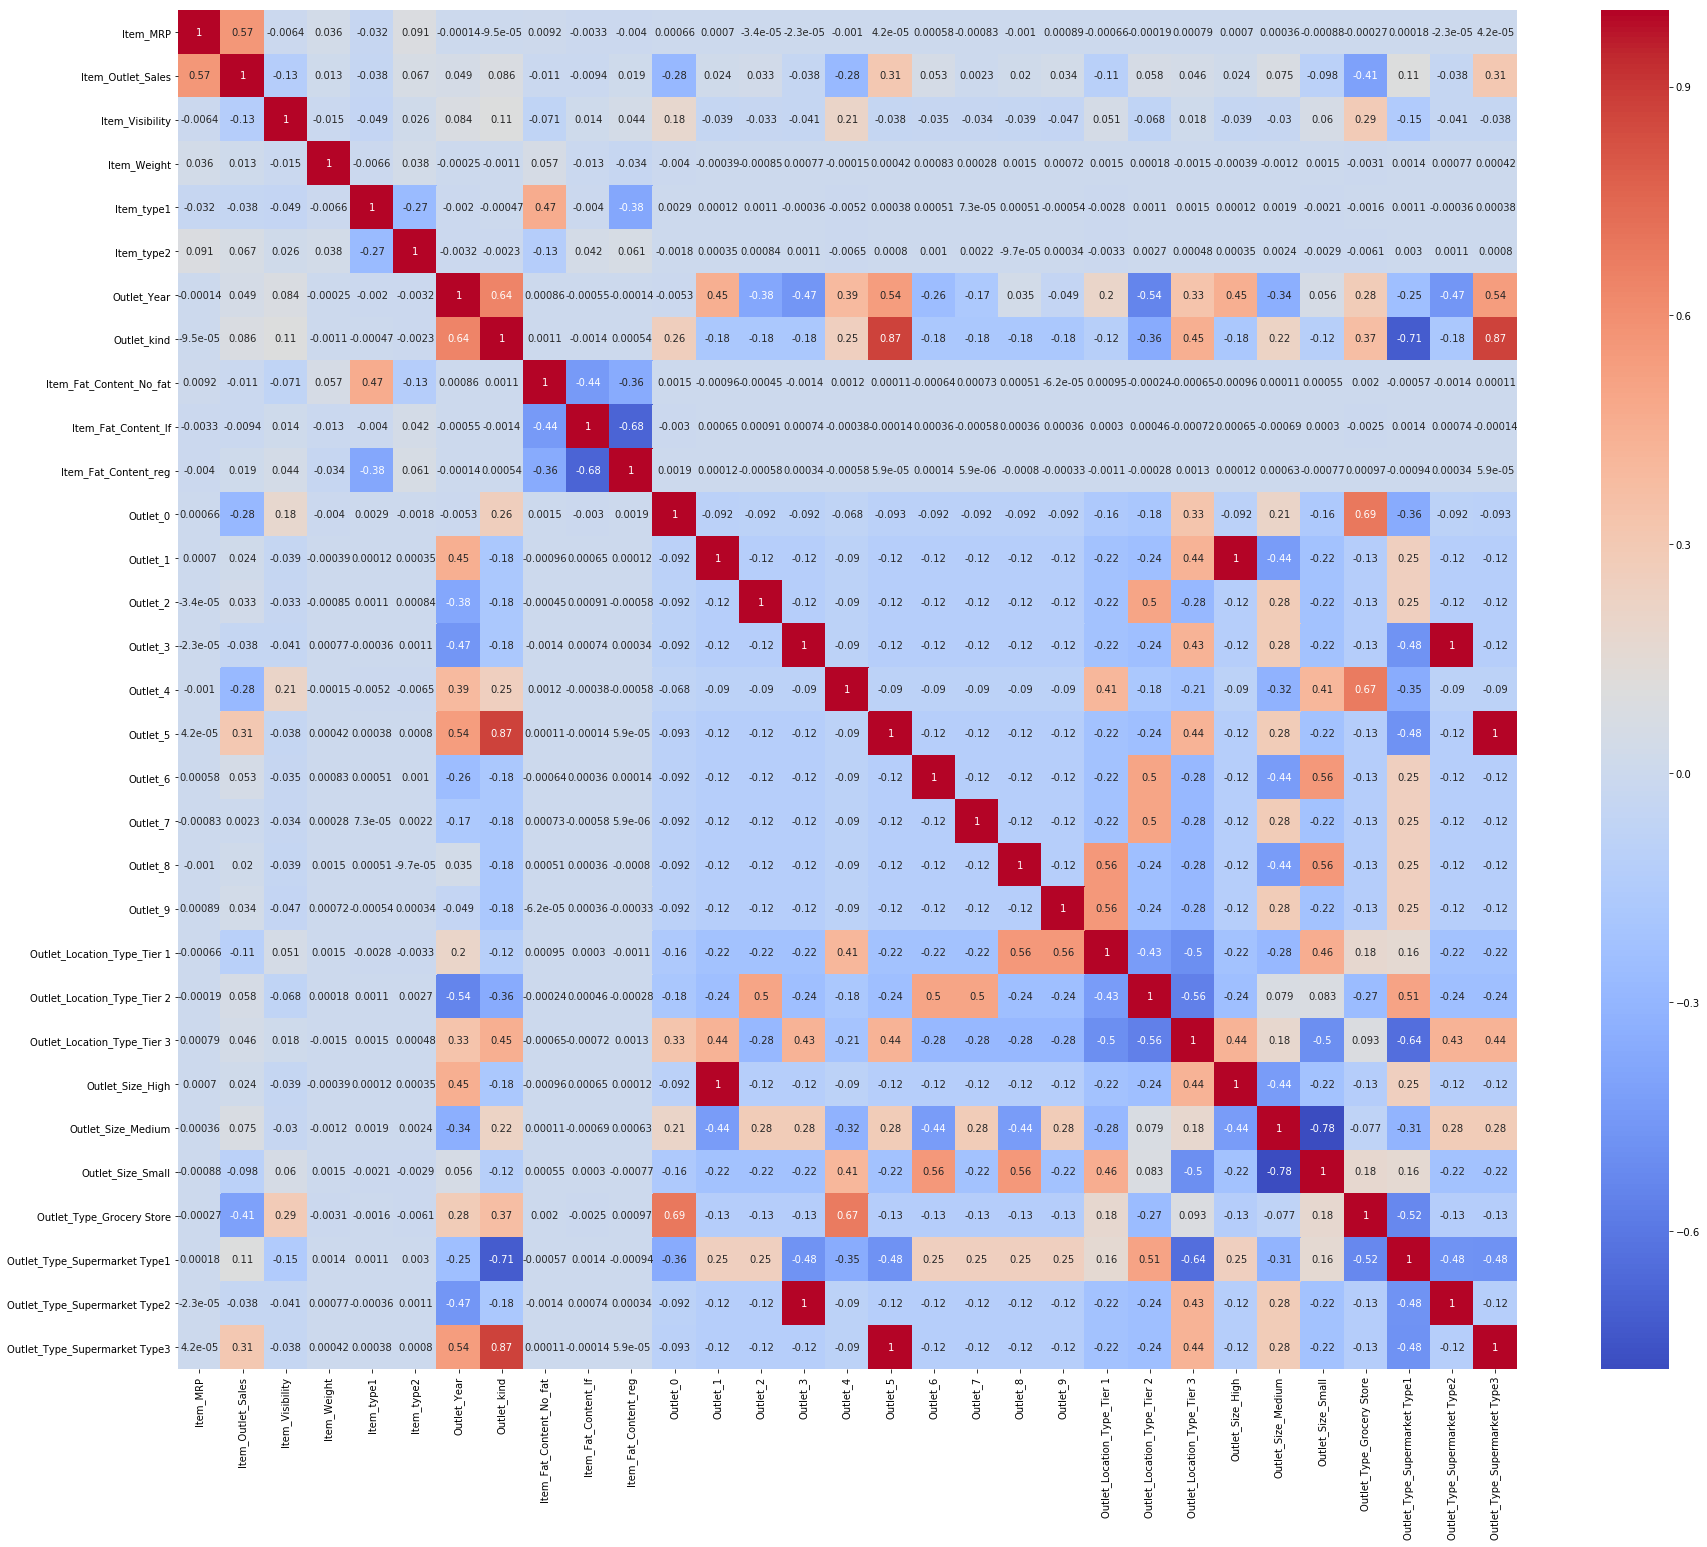

In [68]:
f,ax = plt.subplots(figsize=(30,25))
sns.heatmap(dataset.corr(), annot=True, cmap="coolwarm")

将数据集拆分为train,test，准备建模。

In [69]:
train = dataset[:train_len]
test = dataset[train_len:]

In [70]:
test.drop("Item_Outlet_Sales",axis = 1, inplace=True)

首先我们来查看一下如果用产品的平均销售额来填充test集会获得什么效果：

In [72]:
base_predict = test[["Item_Identifier","Outlet_Identifier"]]

In [73]:
table = pd.pivot_table(train, index=["Item_Identifier"],values=["Item_Outlet_Sales"])

In [74]:
base_predict["Item_Outlet_Sales"] = base_predict.apply(lambda x:table.ix[x["Item_Identifier"], "Item_Outlet_Sales"], axis=1)

In [75]:
base_predict.to_csv("base_predict.csv",index=False)

如果只用平均销售额来填充的test predict,最后的RMSE score 是1598分。

In [ ]:
下面整理数据，把属性值和目标值分开，设为x_train,y_train,x_test,我们的目标就是预测y_test。

In [76]:
y_train = train["Item_Outlet_Sales"]
train_ID = train[["Item_Identifier","Outlet_Identifier"]]
x_train = train.drop(["Item_Identifier","Outlet_Identifier","Item_Outlet_Sales"], axis =1)
x_test = test.drop(["Item_Identifier","Outlet_Identifier"], axis = 1)

In [ ]:
评估一个模型性能的比较好的方式是将训练集划分为更小的训练集和验证集，这种方式叫做交叉验证法。kfold就是将原来的训练集复制成k份，再将任意的训练集划分成
k等fold，也就是说划分好后会训练模型k次，每次选取不同的fold,而其他的k-1份fold作为训练集，结果就是包含k个评估分数的数组。

In [77]:
#split dataset in cross-validation
kfold = StratifiedKFold(n_splits=10)

下面是模型函数：

In [88]:
def modelfit(reg, x_train, y_train, x_test, kfold, base_predict, filename):
    reg.fit(x_train,y_train)
    
    cv_score = cross_val_score(reg, x_train, y_train, scoring="neg_mean_squared_error",cv=kfold)
    
    cv_score = np.sqrt(-cv_score)
    
    print(reg.__class__.__name__,'report','\n')
    print("CV_score: Mean: %f, Std: %f " %(np.mean(cv_score), (np.std(cv_score))))
    base_predict["Item_Outlet_Sales"] = reg.predict(x_test)
    base_predict.to_csv(filename, index=False)

In [137]:
def plot_learning_curve(estimator,x,y,cv=kfold,scoring=None,
                       n_jobs=-1,train_sizes = np.linspace(0.1,1.0,10)):
    plt.figure()
    plt.xlabel("Training examples")
    plt.ylabel("RMSE")
    train_sizes,train_scores,test_scores = learning_curve(
        estimator,x,y,cv=cv,n_jobs=n_jobs,train_sizes = train_sizes,scoring="neg_mean_squared_error")
    train_scores_mean = np.sqrt(-train_scores.mean(axis= 1))
    test_scores_mean = np.sqrt(-test_scores.mean(axis= 1))
    plt.grid()
    plt.plot(train_sizes, train_scores_mean,'o-',color = 'r',label = "training score")
    plt.plot(train_sizes, test_scores_mean,'o-',color = 'g',label = 'Cross-validation score') 
    plt.legend(loc="best")
    return plt

首先使用线性回归算法来预测销售额。

LinearRegression report 

CV_score: Mean: 978.993725, Std: 171.784247 


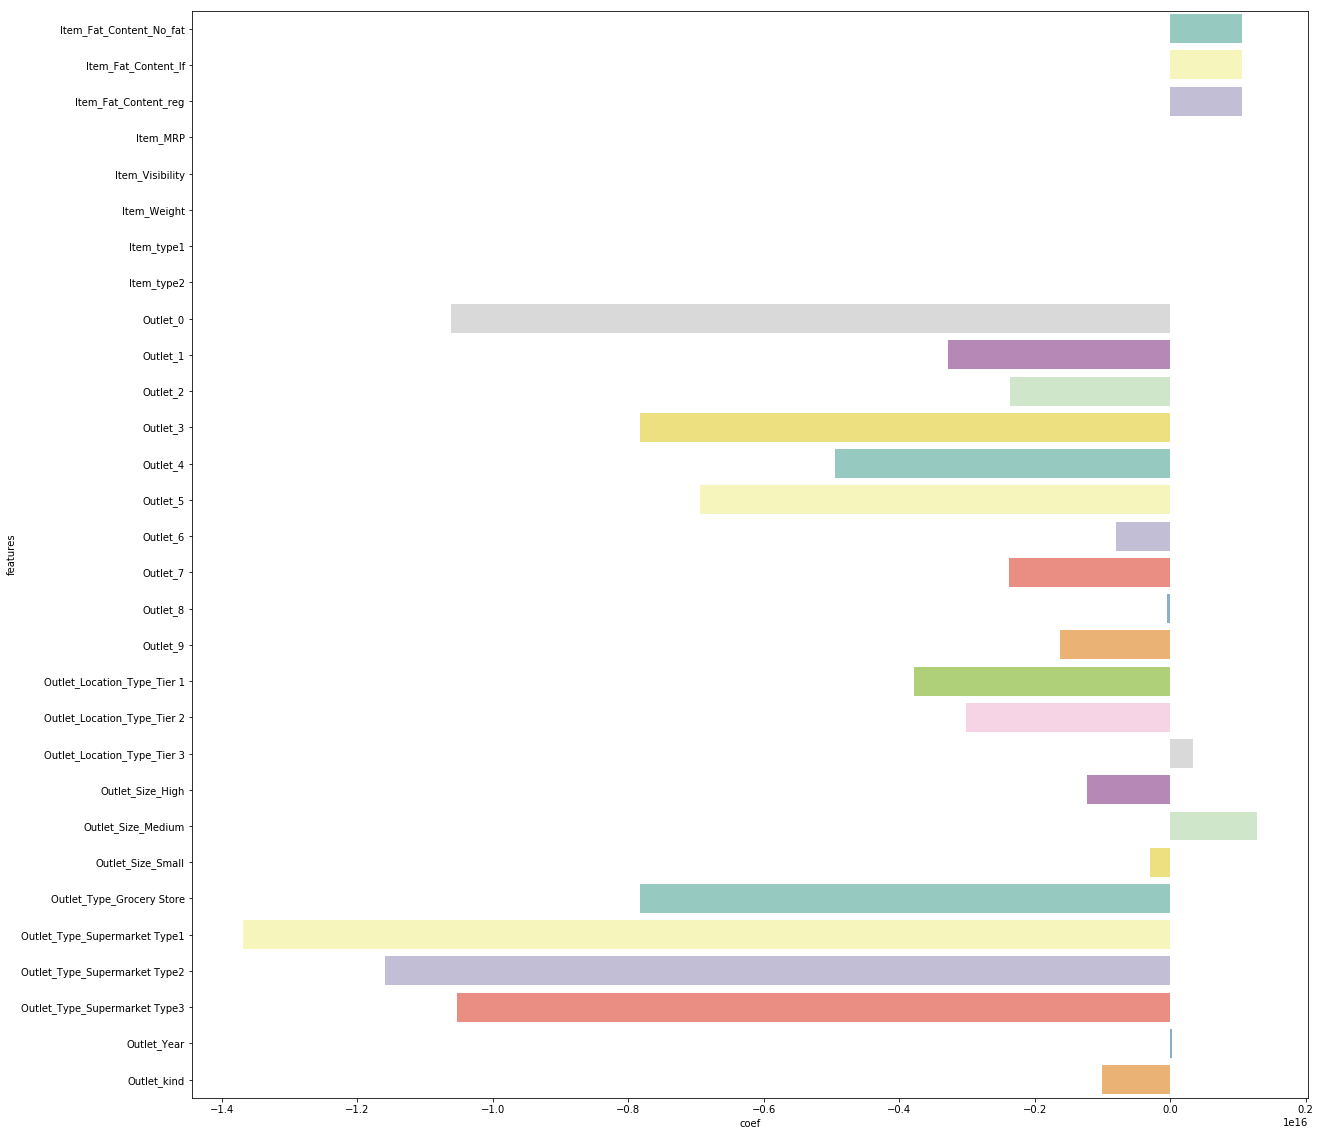

In [138]:
lin_reg = LinearRegression(normalize=True)
modelfit(lin_reg,x_train,y_train,x_test,kfold, base_predict,"lrg_predict")
coeff = pd.DataFrame({"coef":lin_reg.coef_,"features":x_train.columns}).sort_index(by="features")
plt.figure(figsize=(20,20))
g = sns.barplot("coef","features",data = coeff,palette = "Set3",orient = "h")

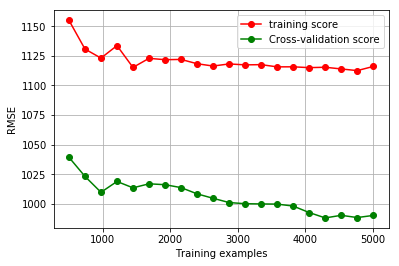

In [140]:
g = plot_learning_curve(lin_reg,x_train,y_train,cv=kfold,scoring="neg_mean_squared_error",n_jobs=1,train_sizes=np.linspace(0.1,1.0,20))

Ridge report 

CV_score: Mean: 978.924512, Std: 173.364491 


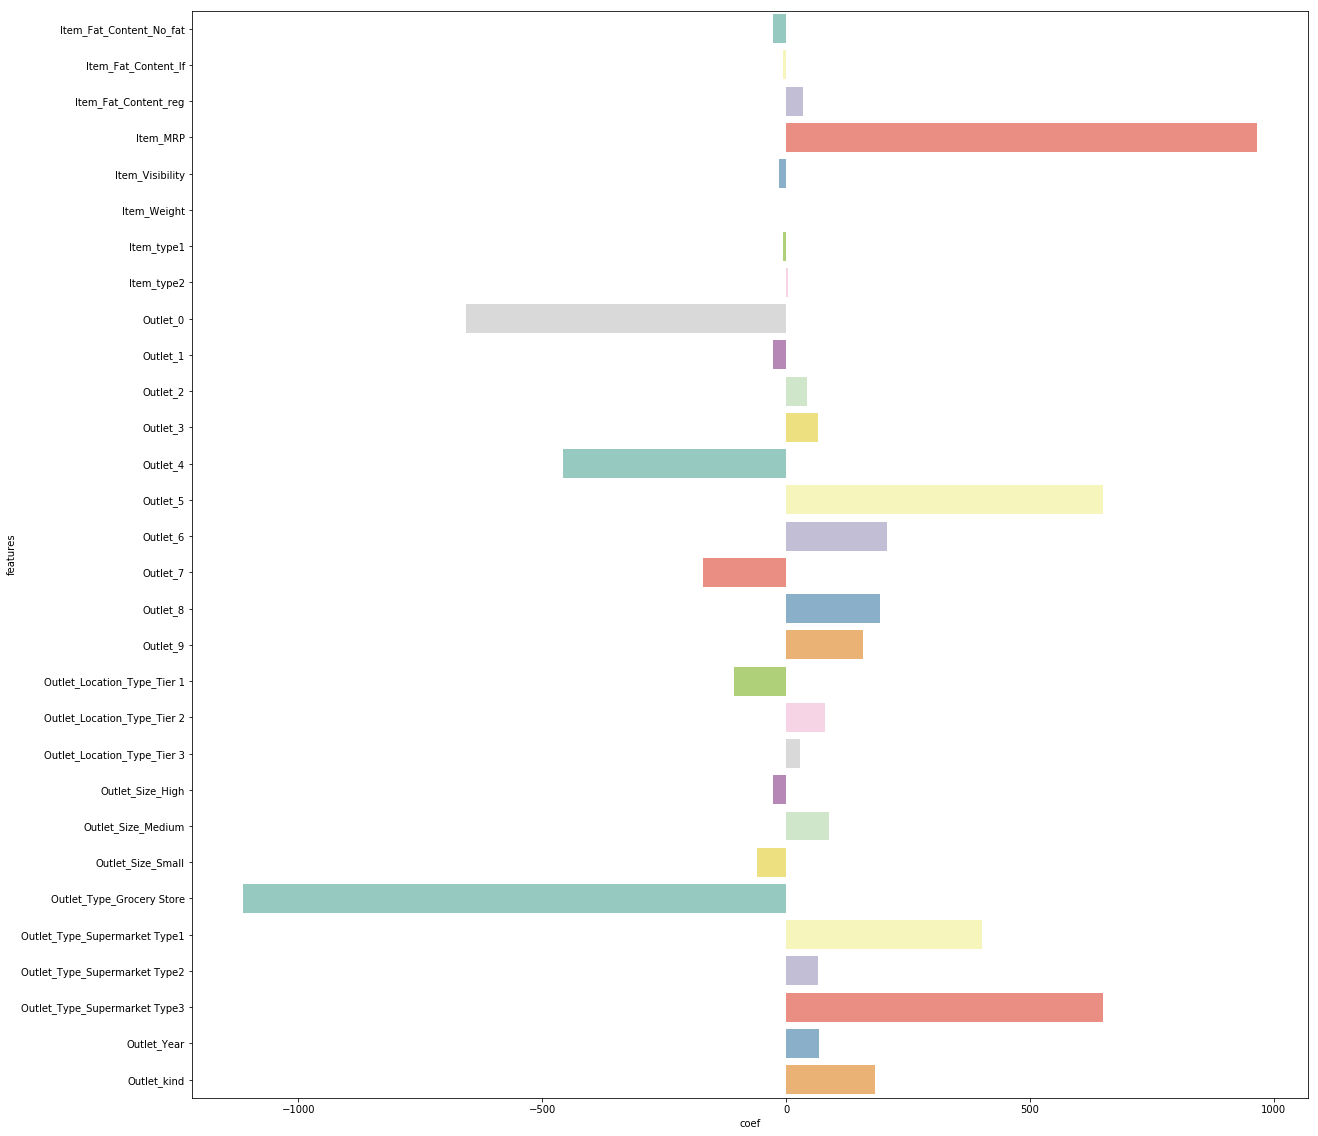

In [90]:
ridge_reg = Ridge(alpha =0.01,max_iter=100)
modelfit(ridge_reg,x_train,y_train,x_test,kfold, base_predict,"lrg_predict.csv")
coeff = pd.DataFrame({"coef":ridge_reg.coef_,"features":x_train.columns}).sort_index(by="features")
plt.figure(figsize=(20,20))
g = sns.barplot("coef","features",data = coeff,palette = "Set3",orient = "h")

In [91]:
ridge_reg = Ridge()
ridge_param = {"max_iter":[100,200,300],
              "alpha":[0.01,0.005,0.0001]}
ridge_gsCV = GridSearchCV(ridge_reg, param_grid=ridge_param, cv=kfold, scoring="neg_mean_squared_error", verbose = 1)
ridge_gsCV.fit(x_train, y_train)
ridge_best = ridge_gsCV.best_estimator_
print(ridge_best)
print(np.sqrt(-ridge_gsCV.best_score_))

Fitting 10 folds for each of 9 candidates, totalling 90 fits
Ridge(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=100,
   normalize=False, random_state=None, solver='auto', tol=0.001)
1198.26056672


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.9s finished


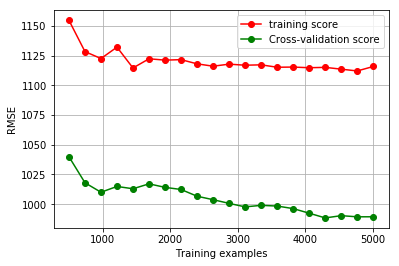

In [141]:
g = plot_learning_curve(ridge_reg,x_train,y_train,cv=kfold,scoring="neg_mean_squared_error",n_jobs=1,train_sizes=np.linspace(0.1,1.0,20))

Ridge report 

CV_score: Mean: 978.925188, Std: 173.363498 


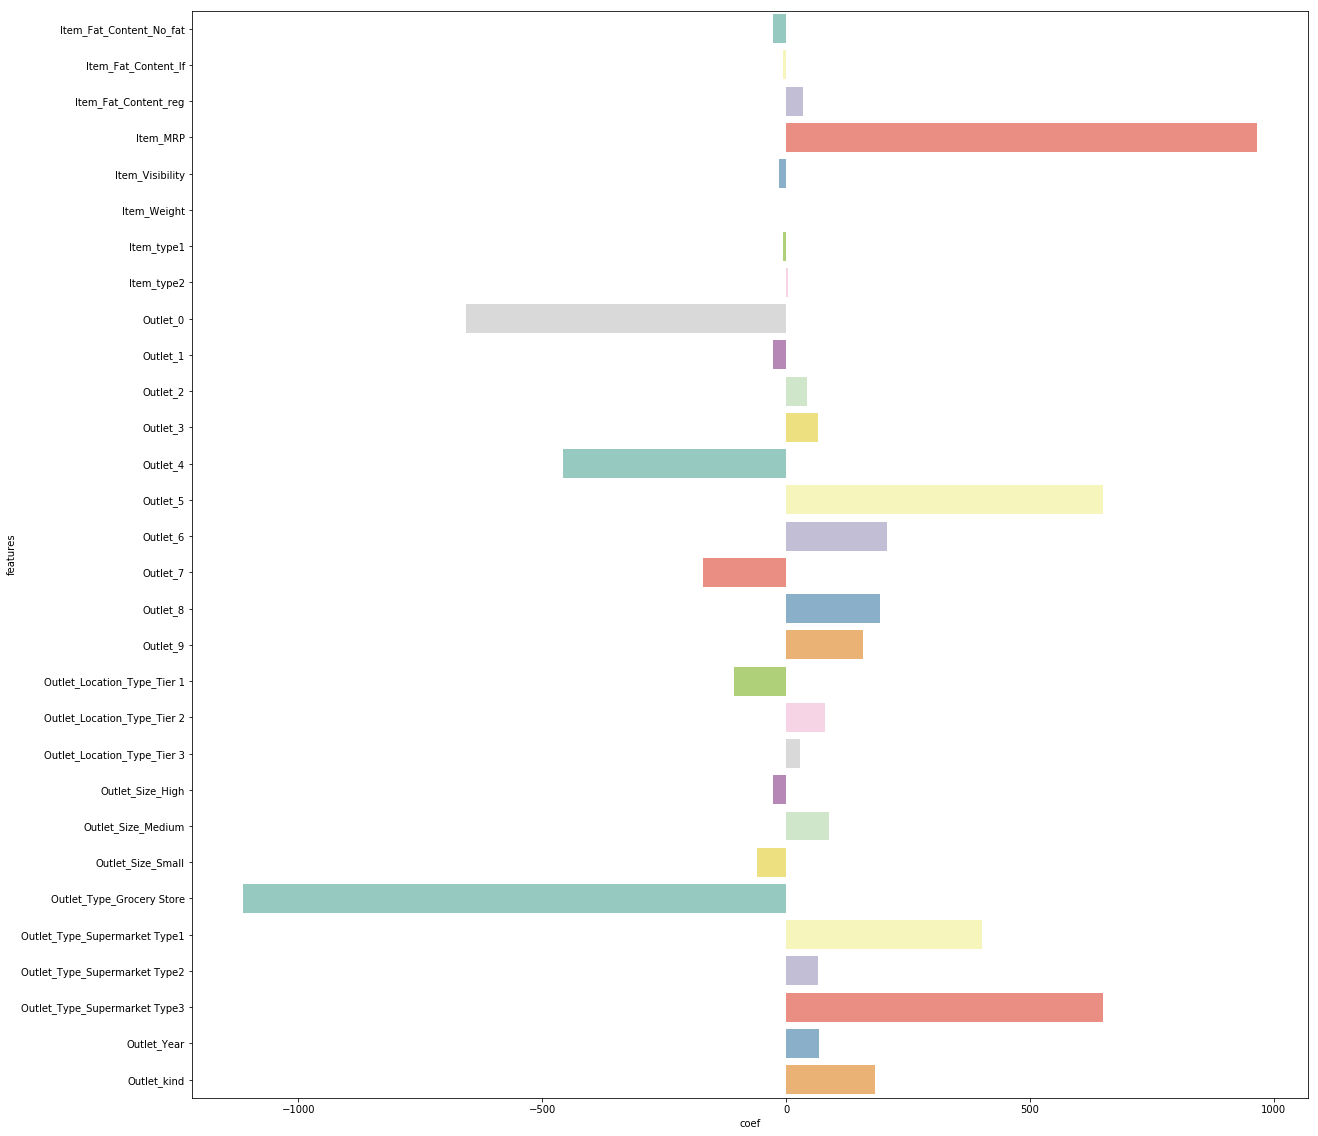

In [92]:
modelfit(ridge_best,x_train,y_train,x_test,kfold, base_predict,"ridge_predict.csv")
coeff = pd.DataFrame({"coef":ridge_best.coef_,"features":x_train.columns}).sort_index(by="features")
plt.figure(figsize=(20,20))
g = sns.barplot("coef","features",data = coeff,palette = "Set3",orient = "h")

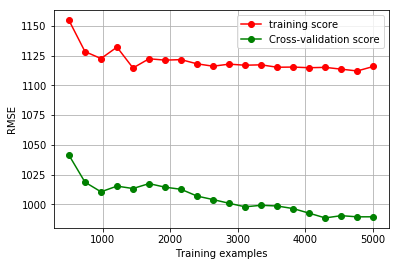

In [142]:
g = plot_learning_curve(ridge_best,x_train,y_train,cv=kfold,scoring="neg_mean_squared_error",n_jobs=1,train_sizes=np.linspace(0.1,1.0,20))

In [93]:
decisiontree_reg = DecisionTreeRegressor()

DecisionTreeRegressor report 

CV_score: Mean: 1363.791365, Std: 185.710519 


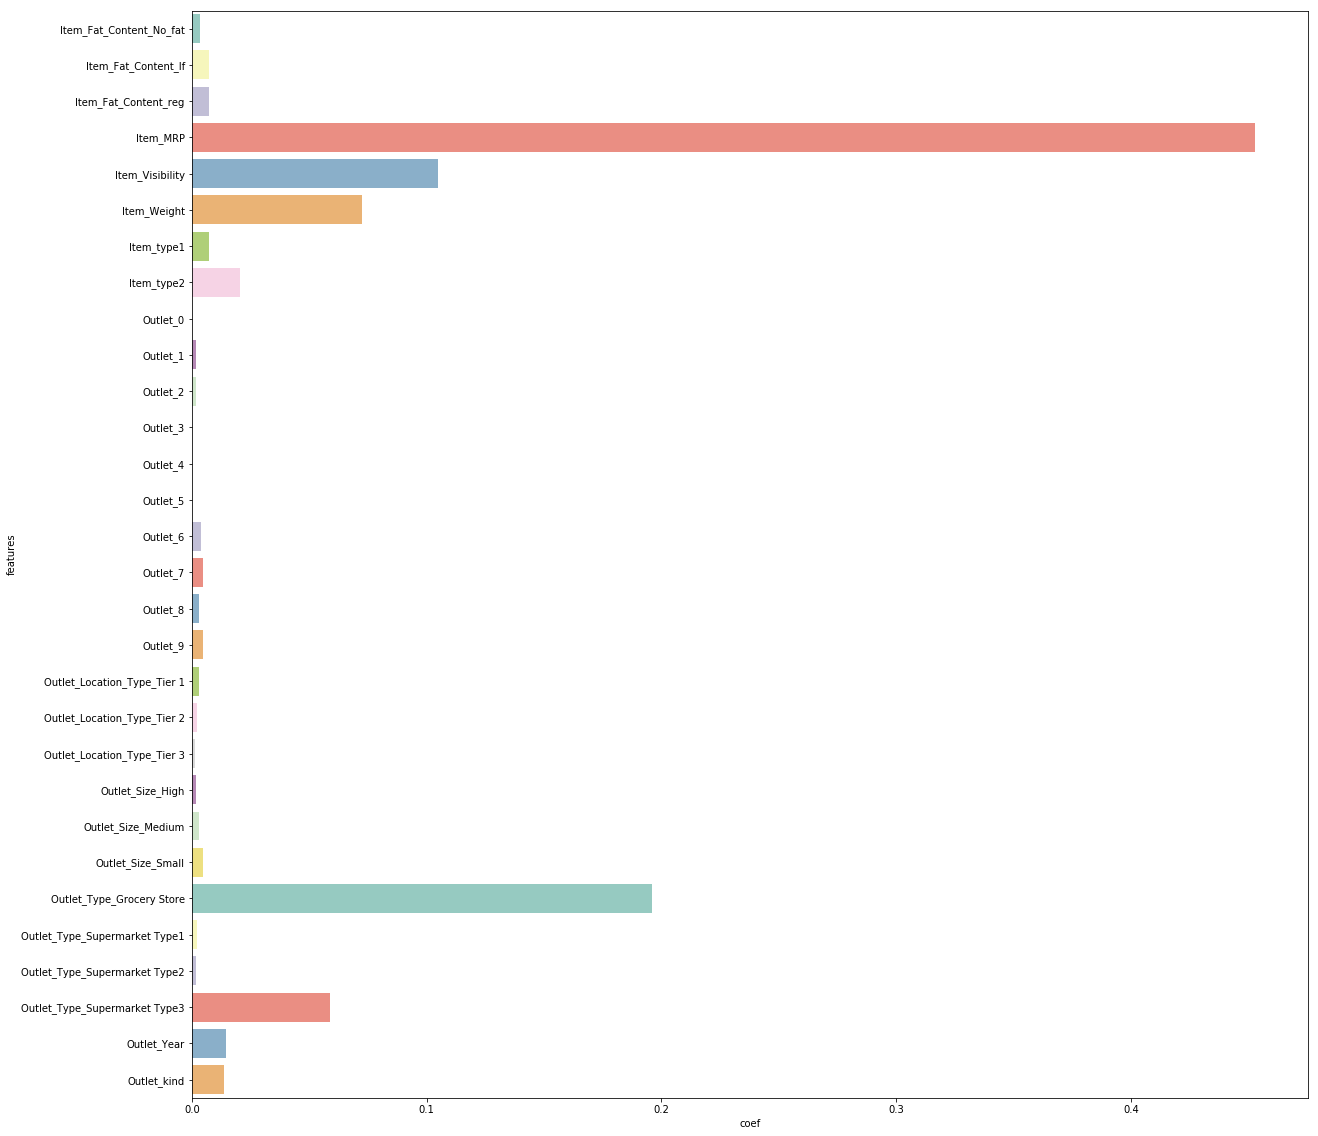

In [94]:
modelfit(decisiontree_reg,x_train,y_train,x_test,kfold, base_predict,"decisionTree_predict.csv")
coeff = pd.DataFrame({"coef":decisiontree_reg.feature_importances_,"features":x_train.columns}).sort_index(by="features")
plt.figure(figsize=(20,20))
g = sns.barplot("coef","features",data = coeff,palette = "Set3",orient = "h")

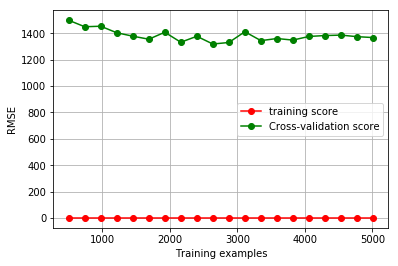

In [143]:
g = plot_learning_curve(decisiontree_reg,x_train,y_train,cv=kfold,scoring="neg_mean_squared_error",n_jobs=1,train_sizes=np.linspace(0.1,1.0,20))

In [95]:
decisiontree_reg = DecisionTreeRegressor()
dt_param = {"max_depth":[10,15,5],
           "min_samples_split":[120,150,160],
           "min_samples_leaf":[80,100,50],
           "max_features":["auto","log2",None]}
dt_gsCV = GridSearchCV(decisiontree_reg, param_grid=dt_param, cv=kfold, scoring="neg_mean_squared_error",n_jobs=-1, verbose = 1)
dt_gsCV.fit(x_train, y_train)
dt_best = dt_gsCV.best_estimator_
print(dt_best)
print(np.sqrt(-dt_gsCV.best_score_))

Fitting 10 folds for each of 81 candidates, totalling 810 fits


[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:    2.4s


DecisionTreeRegressor(criterion='mse', max_depth=5, max_features='auto',
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=80, min_samples_split=160,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')
1164.48250396


[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed:    8.6s finished


DecisionTreeRegressor report 

CV_score: Mean: 955.619680, Std: 175.699873 


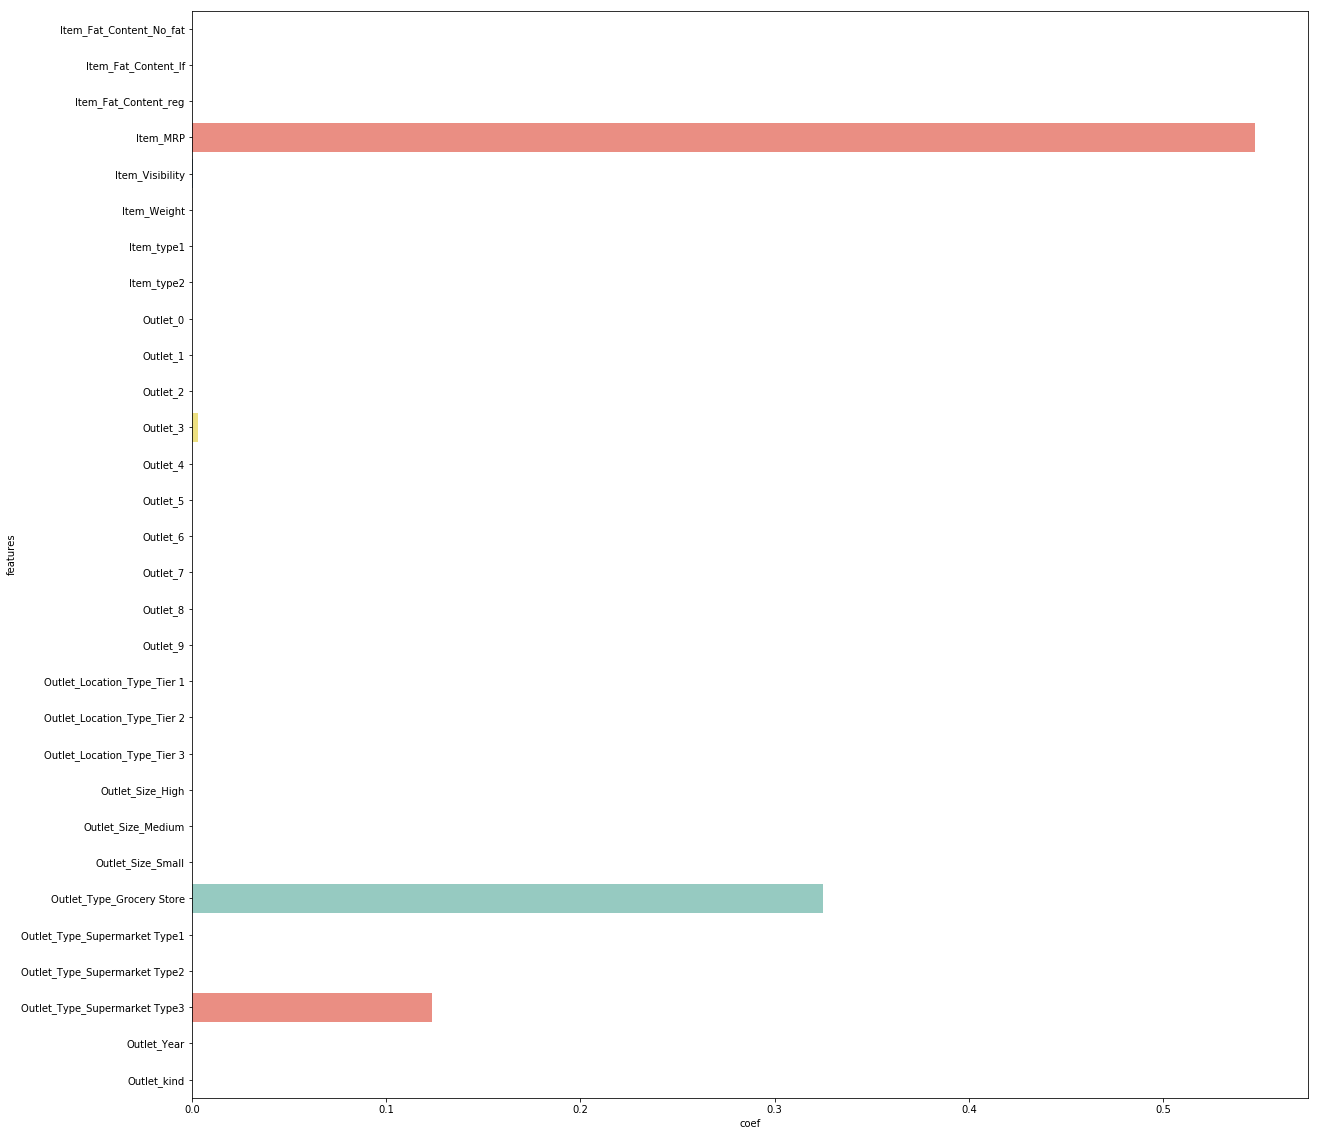

In [96]:
modelfit(dt_best,x_train,y_train,x_test,kfold, base_predict,"decisionTree_predict.csv")
coeff = pd.DataFrame({"coef":dt_best.feature_importances_,"features":x_train.columns}).sort_index(by="features")
plt.figure(figsize=(20,20))
g = sns.barplot("coef","features",data = coeff,palette = "Set3",orient = "h")

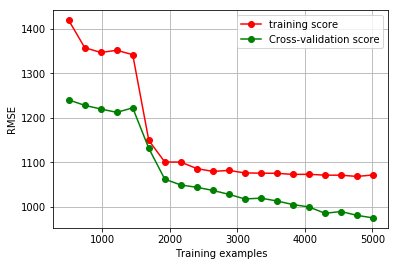

In [145]:
g = plot_learning_curve(dt_best,x_train,y_train,cv=kfold,scoring="neg_mean_squared_error",n_jobs=1,train_sizes=np.linspace(0.1,1.0,20))

RandomForestRegressor report 

CV_score: Mean: 1043.332698, Std: 162.248338 


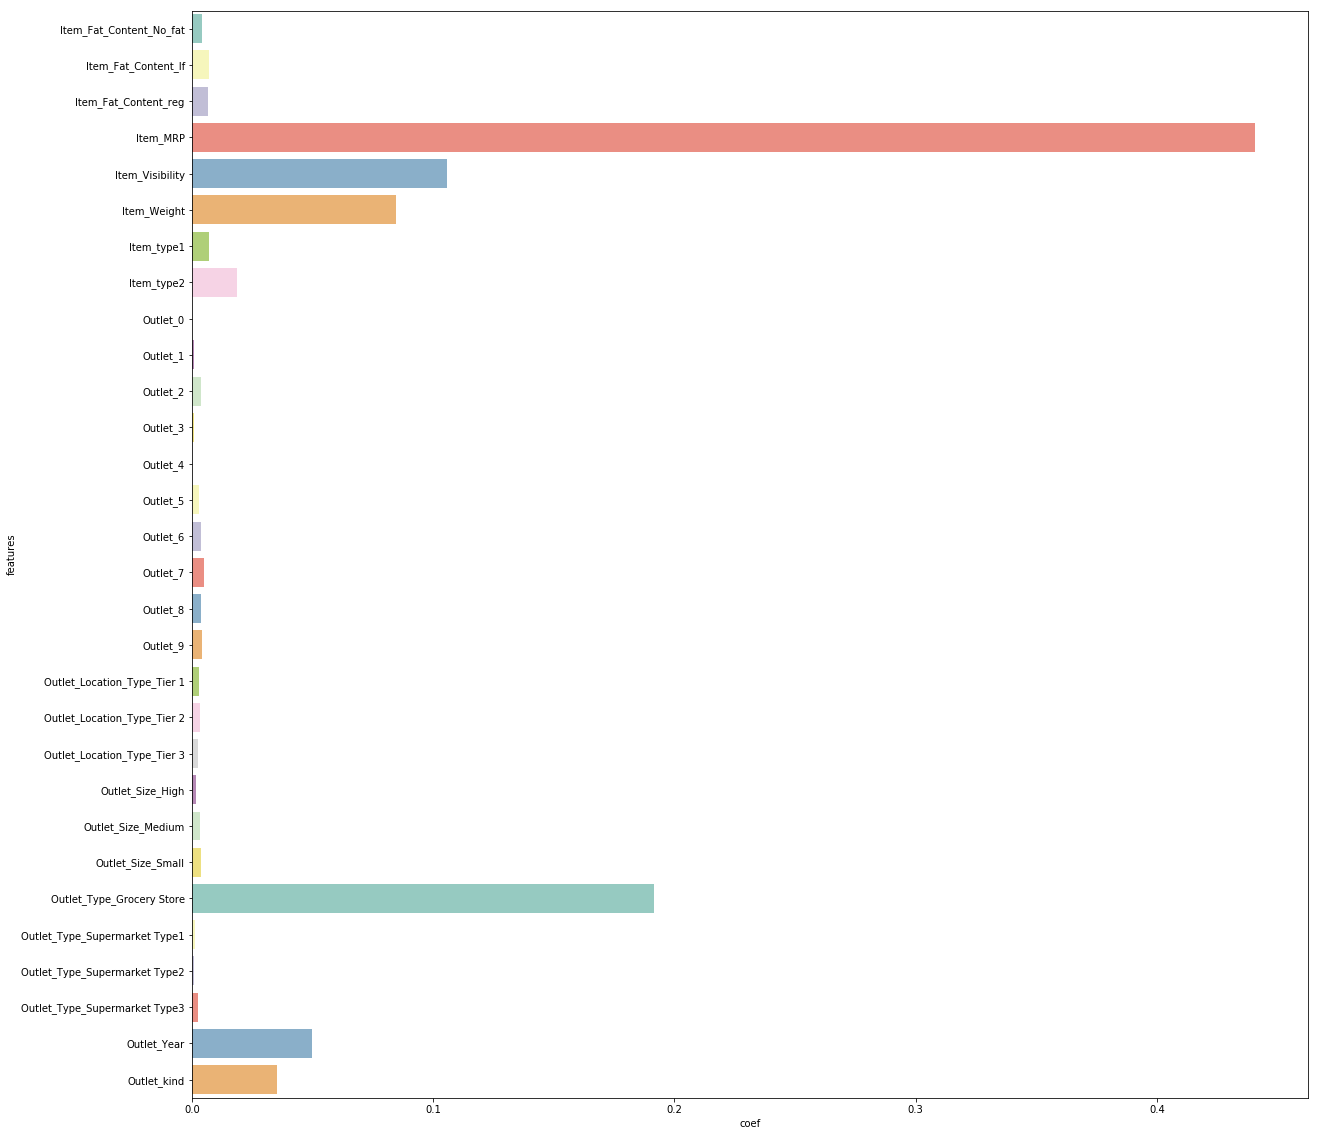

In [97]:
rf_reg = RandomForestRegressor()
modelfit(rf_reg,x_train,y_train,x_test,kfold, base_predict,"RandomForestRegressor_predict.csv")
coeff = pd.DataFrame({"coef":rf_reg.feature_importances_,"features":x_train.columns}).sort_index(by="features")
plt.figure(figsize=(20,20))
g = sns.barplot("coef","features",data = coeff,palette = "Set3",orient = "h")

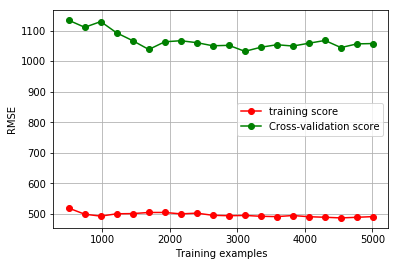

In [146]:
g = plot_learning_curve(rf_reg,x_train,y_train,cv=kfold,scoring="neg_mean_squared_error",n_jobs=1,train_sizes=np.linspace(0.1,1.0,20))

In [98]:
rf_reg = RandomForestRegressor()
rf_param = {"n_estimators":[10,50,5],
           "max_depth":[3,5,7,9],
           "min_samples_split":[4,6,8],
           "min_samples_leaf":[1,10,15]
           }
rf_gsCV = GridSearchCV(rf_reg, param_grid=rf_param, cv=kfold, scoring="neg_mean_squared_error",n_jobs=-1, verbose = 1)
rf_gsCV.fit(x_train, y_train)
rf_best = rf_gsCV.best_estimator_
print(rf_best)
print(np.sqrt(-rf_gsCV.best_score_))

Fitting 10 folds for each of 108 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 339 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 589 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 939 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed:  2.9min finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=10,
           min_samples_split=6, min_weight_fraction_leaf=0.0,
           n_estimators=50, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)
1152.81463053


RandomForestRegressor report 

CV_score: Mean: 950.722001, Std: 169.879424 


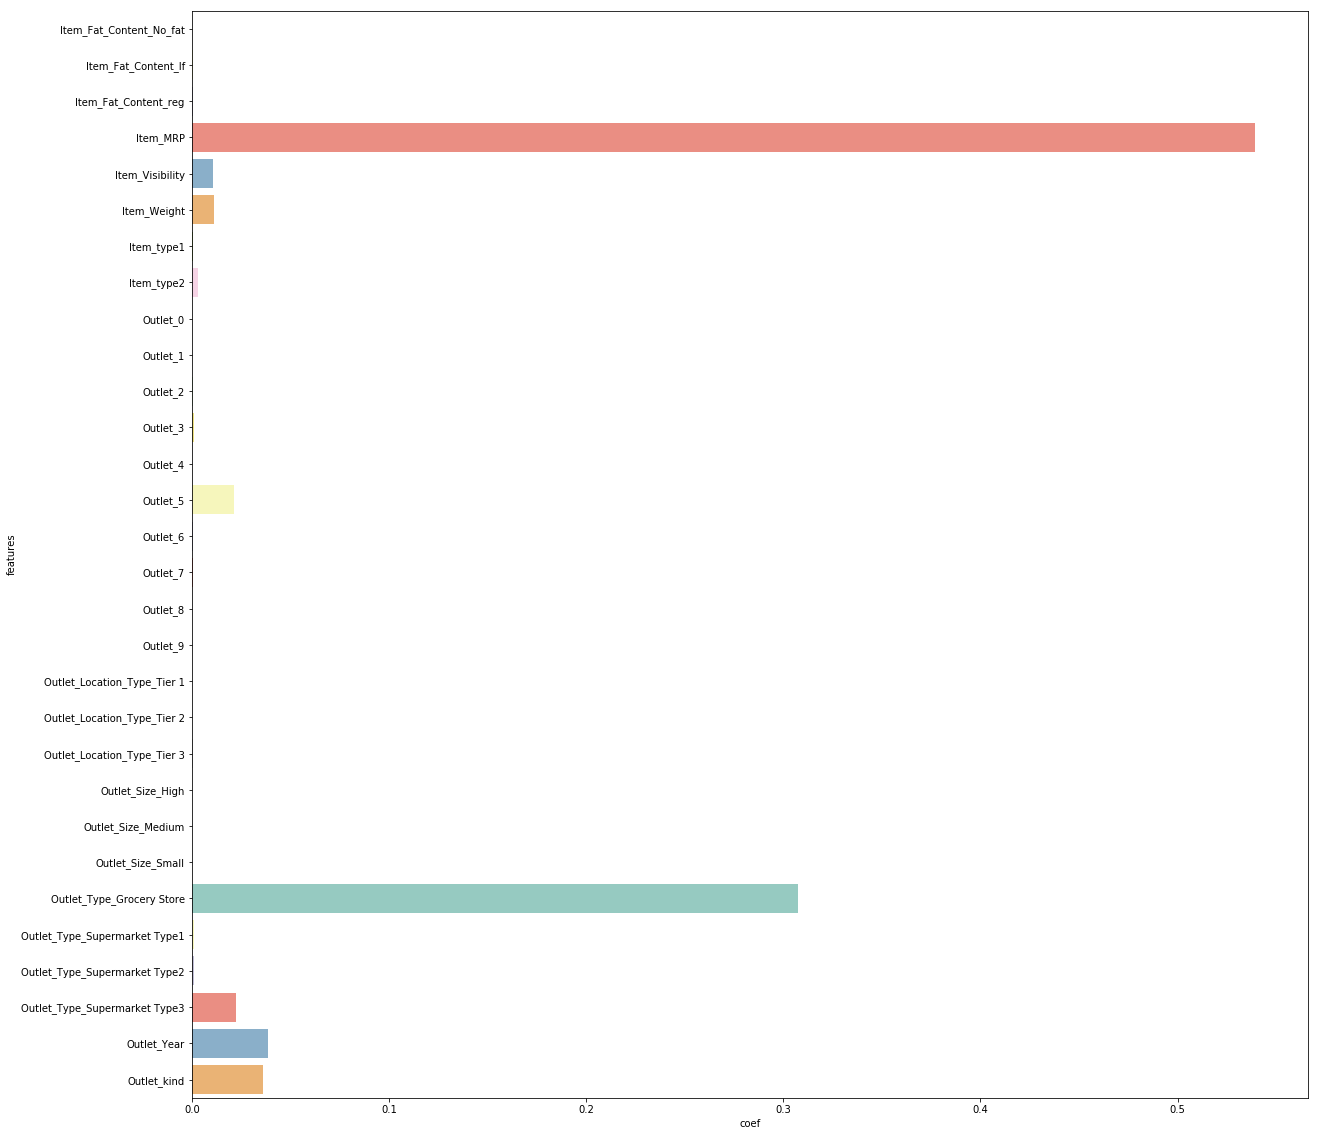

In [110]:
modelfit(rf_best,x_train,y_train,x_test,kfold, base_predict,"RandomForestRegressor_predict.csv")
coeff = pd.DataFrame({"coef":rf_best.feature_importances_,"features":x_train.columns}).sort_index(by="features")
plt.figure(figsize=(20,20))
g = sns.barplot("coef","features",data = coeff,palette = "Set3",orient = "h")

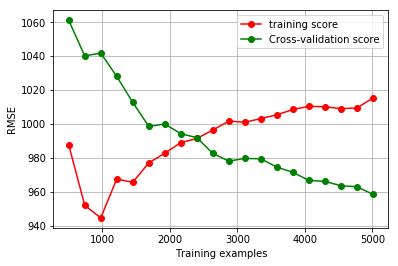

In [147]:
g = plot_learning_curve(rf_best,x_train,y_train,cv=kfold,scoring="neg_mean_squared_error",n_jobs=1,train_sizes=np.linspace(0.1,1.0,20))